In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline


## 1. Загрузка и подготовка данных для анализа

In [56]:
data = pd.read_csv('data.csv')
data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [57]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
Item_Identifier              8523 non-null object
Item_Weight                  7060 non-null float64
Item_Fat_Content             8523 non-null object
Item_Visibility              8523 non-null float64
Item_Type                    8523 non-null object
Item_MRP                     8523 non-null float64
Outlet_Identifier            8523 non-null object
Outlet_Establishment_Year    8523 non-null int64
Outlet_Size                  6113 non-null object
Outlet_Location_Type         8523 non-null object
Outlet_Type                  8523 non-null object
Item_Outlet_Sales            8523 non-null float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.1+ KB


**Для упрощения доступа к свойствам, целесообразно назначить им более короткие имена:**

In [58]:
columns = ['i_id', 'i_weight', 'i_fat', 'i_visibility', 'i_type', 'i_mrp', 'o_id', 'o_year', 'o_size', 'o_location', 'o_type', 'i_sales']

In [59]:
data.columns=columns

**Необходимо провести "очистку" по категориальным переменным:**

Нашлась одна переменная с разнобоем в именах категорий. После очистки можно будет сделать ее бинарной.

In [60]:
data.i_fat.value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: i_fat, dtype: int64

In [61]:
data.loc[data.i_fat.isin(['LF','low fat']),'i_fat']='Low Fat'
data.loc[data.i_fat.isin(['reg']),'i_fat']='Regular'

In [62]:
data.i_fat.value_counts()

Low Fat    5517
Regular    3006
Name: i_fat, dtype: int64

## 2. Общий анализ данных. Устранение нулевых значений

**Для начала проведен анализ числовых параметров - гистограммы и точечные диаграммы покажут характер распределений и зависимости параметров.**

**К сожалению, сильно выраженная кореляция с целевым параметром наблюдается явно только у параметров Item_Visibility и Item_MRP, что логично. Параметр Weight совешенно никакого влияния не оказывает на продажи. Возможно, можно будет избавиться от него, поскольку он может создавать зашумление.**

/data/user/0/ru.iiec.pydroid3/files/aarch64-linux-android/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/data/user/0/ru.iiec.pydroid3/files/aarch64-linux-android/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


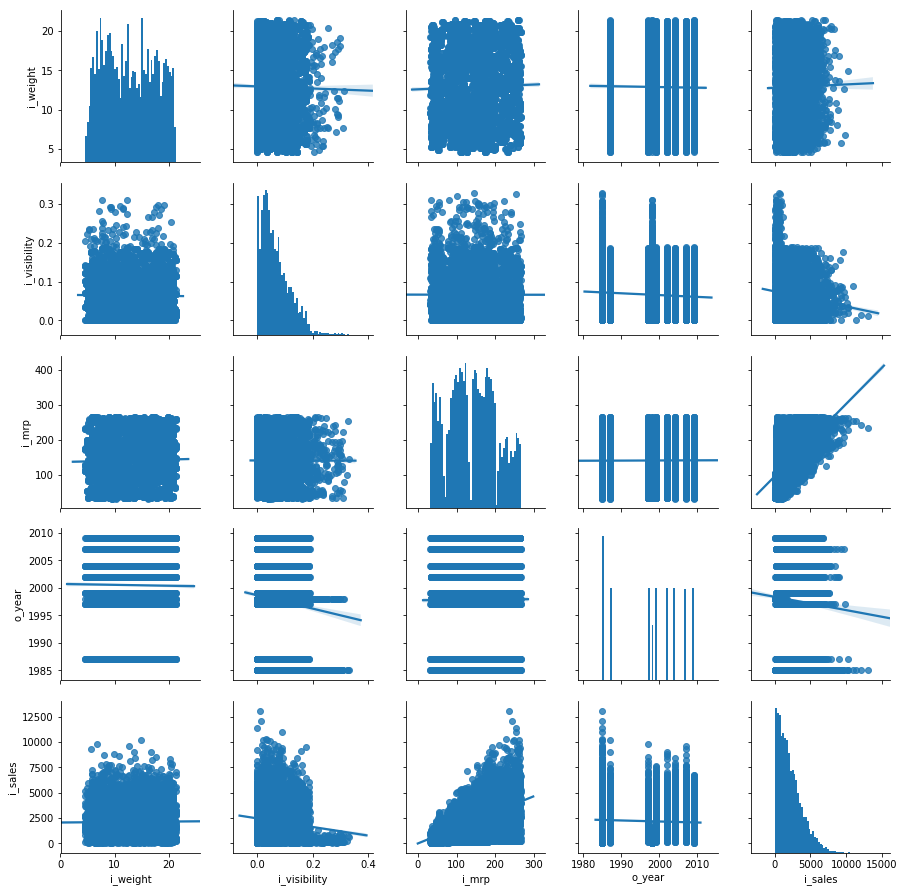

In [9]:
sns.pairplot(data, kind='reg', diag_kws=dict(bins=50))

**Ниже проведен анализ категориальных параметров.**

**Первым делом следует посмотреть на количество магазинов и зависимость продаж в каждом из них от таких параметров, как Type и Location.**

**Из графика можно сделать вывод, что продажи от расположения сильно не зависят, только от типа магазина. При этом, магазин Type 2 немного выбивается, так как имеет, с одной стороны, порядковый номер, который должен говорить о размере, с другой - продажи там ниже, чем в Type 1.**

In [63]:
len(data['o_id'].unique())

10

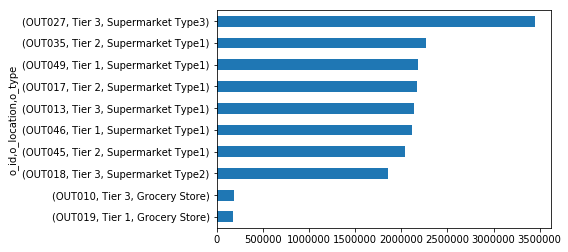

In [64]:
data.groupby(['o_id', 'o_location', 'o_type'])['i_sales'].sum().sort_values().plot(kind='barh')

**Если добавить в группировку еще один параметр, Outlet Size, то, во-первых, некоторые магазины пропали, поскольку имеют нулевые значения; во-вторых, размер магазина так же не показал какого-то значимого различия в продажах**

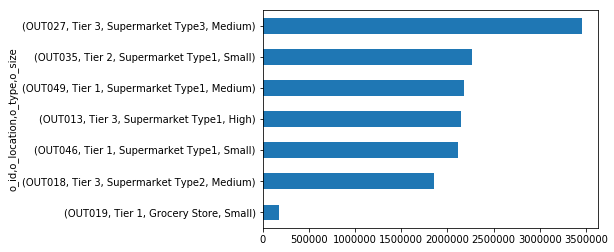

In [65]:
data.groupby(['o_id', 'o_location', 'o_type', 'o_size'])['i_sales'].sum().sort_values().plot(kind='barh')

In [66]:
data[data['o_size'].isnull()]['o_id'].unique()

array(['OUT010', 'OUT045', 'OUT017'], dtype=object)

**Список магазинов, которые не имеют параметра Size состоит из 3 объектов. Если рассмотреть предыдущий график, 2 магазина с отсутствующим значением поля Size имеют продажи, а так же Location и Type, аналогичные магазину OUT035. Таким образом, магазинам OUT045 и OUT017 в параметр Size можно поставить значение Small.**

**Магазин OUT010 с Location = Tier3 может иметь, по аналогии с Supermarket Type1, размер High**

In [67]:
data.loc[data.o_id.isin(['OUT045','OUT017']), 'o_size']='Small'
data.loc[data.o_id == 'OUT010', 'o_size']='High'

In [68]:
data[data['o_size'].isnull()]['o_id'].unique()

array([], dtype=object)

**Можно взглянуть на содержание жира. Продукты с низким содержанием жиров приносят больше продаж, чем с обычным. Покупатели заботятся о здоровье.**

**Показалось необычным, что непищевые позиции имеют значение Regular по содержанию жира. Возможно, следует ввести 3ю категорию, которая отделяла бы эту группу продуктов.**

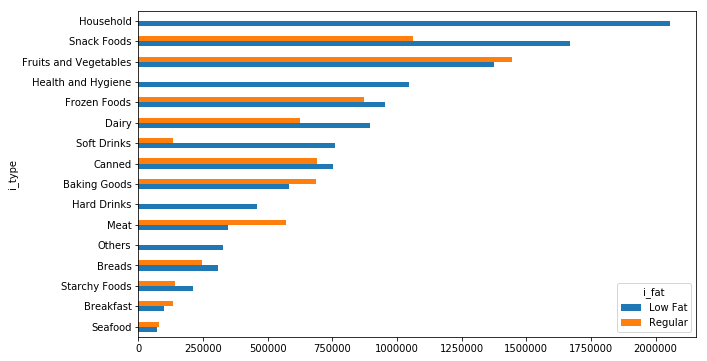

In [69]:
#Для начала следует убедиться, что все товары имеют как варианты с высоким содержанием жира, так и с низким
data.groupby(['i_fat','i_type'])['i_sales'].sum().unstack('i_fat').sort_values(by='Low Fat').plot(kind='barh', figsize=(10, 6))

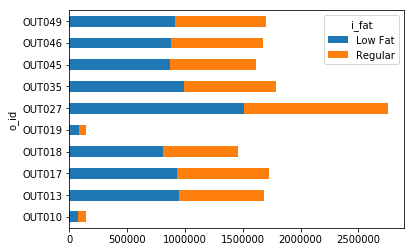

In [70]:
#Для построения диаграммы устранены непищевые категории
data[~data.i_type.isin(['Household', 'Hard Drinks', 'Health and Hygiene', 'Others'])].groupby(['i_fat', 'o_id'])['i_sales'].sum().unstack('i_fat').plot(kind='barh',stacked=True)

In [71]:
#Вводится дополнительная категория в признак Fat
data.loc[data.i_type.isin(['Household', 'Hard Drinks', 'Health and Hygiene', 'Others']), 'i_fat'] = 'No Fat'

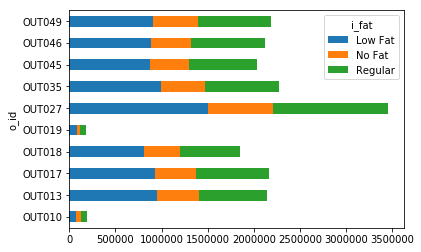

In [72]:
data.groupby(['i_fat', 'o_id'])['i_sales'].sum().unstack('i_fat').plot(kind='barh',stacked=True)

In [73]:
data.i_fat.unique()

array(['Low Fat', 'Regular', 'No Fat'], dtype=object)

**Ранее было замечено, что параметр Weight не коррелиурет с уровнем продаж, однако, списывать его пока не следует, так как он может быть связан с другими характеристиками. Чтобы использовать его, нужно убрать нулевые значения.**

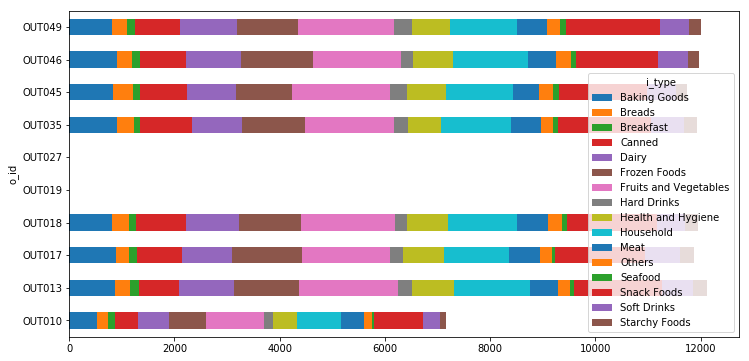

In [74]:
data.groupby(['o_id', 'i_type'])['i_weight'].sum().unstack().plot(kind='barh', figsize=(12,6), stacked=True)


**Удаление нулевых значений для параметра Weight ниже**

In [75]:
df1 = data[data.i_weight.isnull()][['i_id']]
df2 = data[~data.i_weight.isnull()][['i_id', 'i_weight']].drop_duplicates(subset='i_id', keep='first')


In [76]:
df = df1.merge(df2, on='i_id', how='left')

In [77]:
df.index = df1.index

In [78]:
data.loc[df1.index, 'i_weight'] = df['i_weight']

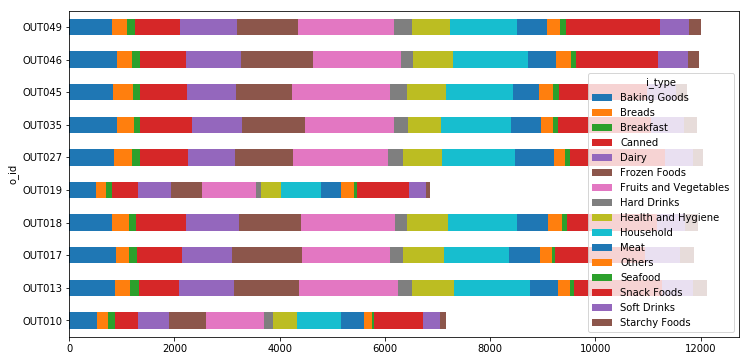

In [79]:
data.groupby(['o_id', 'i_type'])['i_weight'].sum().unstack().plot(kind='barh', figsize=(12,6), stacked=True)

**Для 4 товаров не удается заполнить значение поля Weight, так как они присутствуют в единичном экземпляре. Их можно удалить целиком.**

In [80]:
data = data.dropna()

**Обратил на себя внимание факт, что для некоторых товаров параметр Visibility имеет значение 0. При этом, если рассмотреть этот параметр суммарно в разрезе каждого магазина, то его значение остается в районе 56%, таким образом, нельзя сделать вывод, что нулевые значения случайны и являются результатом ошибок. Поэтому, никаких изменений здесь проводить не надо.**

In [81]:
data.groupby(['o_id'])['i_visibility'].sum()

o_id
OUT010    56.308832
OUT013    55.879859
OUT017    56.834646
OUT018    56.621454
OUT019    57.065541
OUT027    54.564185
OUT035    56.974873
OUT045    56.180780
OUT046    56.231875
OUT049    56.549156
Name: i_visibility, dtype: float64

## 3. Обработка категориальных признаков

**Item Id и Outlet Id можно удалить - больше они не понадобятся**

In [28]:
data_ = data.drop(['i_id', 'o_id'], axis=1)


**Размер и расположение магазинов будут закодированы с помощью LabelEnocder, так как порядок может иметь значение**

In [29]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data_['o_size'] = le.fit_transform(data_['o_size'])
data_['o_location'] = le.fit_transform(data_['o_location'])

**Остальные признаки будут закодированы с помощью функции get_dummies**

In [30]:
data_ = pd.get_dummies(data_)

In [31]:
data_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8519 entries, 0 to 8522
Data columns (total 29 columns):
i_weight                        8519 non-null float64
i_visibility                    8519 non-null float64
i_mrp                           8519 non-null float64
o_year                          8519 non-null int64
o_size                          8519 non-null int64
o_location                      8519 non-null int64
i_sales                         8519 non-null float64
i_fat_Low Fat                   8519 non-null uint8
i_fat_Regular                   8519 non-null uint8
i_type_Baking Goods             8519 non-null uint8
i_type_Breads                   8519 non-null uint8
i_type_Breakfast                8519 non-null uint8
i_type_Canned                   8519 non-null uint8
i_type_Dairy                    8519 non-null uint8
i_type_Frozen Foods             8519 non-null uint8
i_type_Fruits and Vegetables    8519 non-null uint8
i_type_Hard Drinks              8519 non-null uint8
i

## 4. Построение модели

In [32]:
X = data_.drop(['i_sales'], axis=1)

**При анализе признаков было замечено, что распределение значений продаж сильно "скошено" влево, и если оставить все как есть, модель может обучиться хорошо на низких значениях продаж, а высокие предсказывать плохо.**

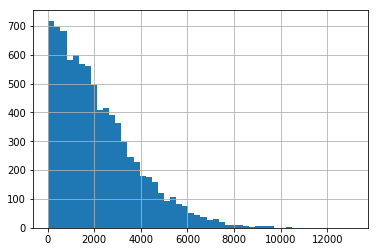

In [33]:
data_.i_sales.hist(bins=50)

**Если применить натуральный логарифм к значениям Sales, то можно получить распределение, близкое к нормальному,  на котором будет легче обучать модель, при этом надо будет преобразовывать обратно пресказанные значения, чтобы получить результат.**

In [34]:
y = np.log(data['i_sales'])

Median:  7.492387529501885
Mean:    7.296597930938213
Mode:    6.865632438728833


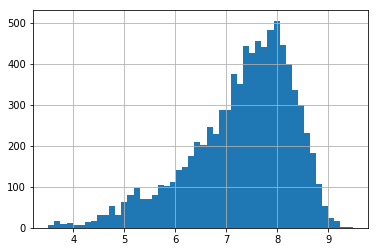

In [35]:
y.hist(bins=50)
print('Median: ', y.median())
print('Mean:   ', y.mean())
print('Mode:   ', y.mode()[0])

**Ниже импортируются функции для подготовки данных, а так же, функции оценки качества.**

**Так как нужно предсказать значение суммы денег, для оценки качества лучше всего подходит MAE, так как она может прямо показать в тех же единицах, как сильно отклонилась модель от истины.**

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
scaler = StandardScaler()

models = {}
grids = {}

In [37]:
scaler.fit(X_train)

/data/user/0/ru.iiec.pydroid3/files/aarch64-linux-android/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


StandardScaler(copy=True, with_mean=True, with_std=True)

### Модели по отдельности

In [38]:
from sklearn.linear_model import Lasso

lasso = Lasso()
params = {'alpha':[0.0001, 0.001, 0.01, 0.1, 1]}
models.update({'lasso':{'model': lasso, 'params': params}})


In [39]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(weights='uniform')
params = {'n_neighbors':range(1,10)}
models.update({'knn':{'model': knn, 'params': params}})

In [40]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
params = {'n_estimators':range(1,10, 1), 'max_depth':range(1, 20)}
models.update({'rfrst':{'model': rf, 'params': params}})

In [41]:
from sklearn.svm import SVR

svr = SVR(gamma='auto')
params = {'C':[100, 10, 1, 0.1, 0.01]}
models.update({'svr':{'model': svr, 'params': params}})

In [42]:
X_trn_scaled = scaler.transform(X_train)
X_tst_scaled = scaler.transform(X_test)
print('Name\tTrain MAE\tTest MAE')

for k, v in models.items():
    grid = GridSearchCV(v.get('model'), v.get('params'), cv=5, iid=False)
    grid.fit(X_trn_scaled, y_train)
    grids.update({k: grid})
    train = mean_absolute_error(np.e**grid.best_estimator_.predict(X_trn_scaled), np.e**y_train)
    test = mean_absolute_error(np.e**grid.best_estimator_.predict(X_tst_scaled), np.e**y_test)
    print(k,'\t{:.0f}\t\t{:.0f}'.format(train, test))

/data/user/0/ru.iiec.pydroid3/files/aarch64-linux-android/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.
/data/user/0/ru.iiec.pydroid3/files/aarch64-linux-android/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  


Name	Train MAE	Test MAE
lasso 	792		775
knn 	778		874
rfrst 	761		763
svr 	706		768


**Результат не очень хороший. Ниже приведен вариант со "Стэкингом" для моделей с гиперпараметрами, подобранными на данном шаге**

### Stacking

In [50]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
kfold = KFold(n_splits=5, shuffle=True)


In [44]:
for k, v in grids.items():
    print(k, v.best_params_)
    

lasso {'alpha': 0.01}
knn {'n_neighbors': 9}
rfrst {'max_depth': 5, 'n_estimators': 9}
svr {'C': 1}


In [45]:
lasso = Lasso(alpha=0.01)
knn = KNeighborsRegressor(n_neighbors=9)
rf = RandomForestRegressor(n_estimators=9, max_depth=5)
svr = SVR(C=1, gamma='auto')

stack = [lasso, knn, rf, svr]

In [47]:
predictions = []

for model in stack:
    meta = np.empty_like(y_train)
    for train, held_out in kfold.split(X_trn_scaled):
        model.fit(np.array(X_trn_scaled)[train], np.array(y_train)[train])
        meta[held_out] = model.predict(np.array(X_trn_scaled)[held_out])
    predictions.append(meta)

In [48]:
predictions = np.stack(predictions, axis=1)

In [51]:
blender = LinearRegression()
blender.fit(predictions, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [52]:
test_predictions = []
for model in stack:
    test_predictions.append(model.predict(X_tst_scaled))
test_predictions = np.stack(test_predictions, axis=1)


In [53]:
print('Train\t:{:.0f}'.format(mean_absolute_error(np.e**blender.predict(predictions), np.e**y_train)))
print('Test\t:{:.0f}'.format(mean_absolute_error(np.e**blender.predict(test_predictions), np.e**y_test)))

Train	:766
Test	:757


**Стэкинг показал себя чуть лучше, чем самая лучшая модель, обученая отдельно.**